In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore',category=UserWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
import W2V2
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student1/sushovan.saha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
glove_path = 'glove.6B.100d.txt'

In [3]:
X_train,y_train = W2V2.Sentence2Vec(filename='Train.xlsx',glovepath=glove_path, embedding_dim=100, max_length=120)

number of word in vocabulary 143699
word in sentences are replaced with word ID [[   3    2   24 ...    9  114 1996]
 [9796  590 2684 ...   61 1065 3100]
 [1958 2002 7091 ... 7257 2133 1951]
 ...
 [   2  900   94 ...  156  882   19]
 [   2   58 1794 ...   57   47   84]
 [3262 3233 4319 ...  472  382 2286]]
The size of vocabulary  143700
Loaded 400000 word vectors.
(26590, 120, 100)


In [4]:
X_test,y_test = W2V2.Sentence2Vec(filename='Test.xlsx',glovepath=glove_path)

number of word in vocabulary 37490
word in sentences are replaced with word ID [[   15  2444  1170 ...  6866  6867   292]
 [ 1849  1254 17674 ... 10294   477   271]
 [   66  3773   922 ...   352  1242    17]
 ...
 [  252   610  3654 ...  2282  1443   403]
 [   36    49    73 ...  4708   219   997]
 [  452   312   956 ...    12   394     6]]
The size of vocabulary  37491
Loaded 400000 word vectors.
(1300, 120, 100)


In [5]:
X_valid,y_valid = W2V2.Sentence2Vec(filename='Valid.xlsx',glovepath=glove_path)

number of word in vocabulary 41258
word in sentences are replaced with word ID [[  678   762  2405 ...   156  1774 13380]
 [20298  1337  3805 ...  7151   474   819]
 [  529   263   409 ...   967    43  2739]
 ...
 [ 1097  1201  1228 ...  1433 25652  8927]
 [  509  1503  2792 ...  8678  1904  8830]
 [  130  1361  9149 ...  2951   613   385]]
The size of vocabulary  41259
Loaded 400000 word vectors.
(2355, 120, 100)


In [6]:
X_train.shape

(26590, 120, 100)

In [7]:
pd.Series(y_train).value_counts()

2    10241
0     8861
1     7488
dtype: int64

In [8]:
pd.Series(y_valid).value_counts()

0    1639
1     618
2      98
dtype: int64

In [9]:
pd.Series(y_test).value_counts()

2    599
0    402
1    299
dtype: int64

In [10]:
max_length = X_train.shape[1]

In [11]:
from torch.autograd import Variable
class myLSTM(nn.Module):

    def __init__(self, dimension):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=dimension,
                            hidden_size=max_length,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=False)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(max_length, 3)
        self.act = nn.Softmax()

    def forward(self, x, batch_size):
        h_0 = Variable(torch.zeros(2, batch_size, max_length))
        c_0 = Variable(torch.zeros(2, batch_size, max_length))
        x, (final_hidden_state, final_cell_state) = self.lstm(x, (h_0, c_0))
        #print(x.shape)
        x = self.fc(final_hidden_state[-1])
        #print(x.shape)
        x = self.act(x)
        return x.squeeze()
        

In [12]:
def train(model, x, y, loss_fn, optimizer, batch_size=1024):
    model.train()
    x, y = torch.Tensor(x), torch.Tensor(y)
    y = y.type(torch.LongTensor)
    net_loss = 0
    
    for i in range(0, len(x), batch_size):
        i_end = i+batch_size
        x_batch = x[i:min(i_end, len(x))]
        y_batch = y[i:min(i_end, len(x))]
        
        pred = model(x_batch,x_batch.shape[0])
        loss = loss_fn(pred, y_batch)
        net_loss = net_loss+loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return net_loss

def test(model, xts, yts,batchsize):
    model.eval()
    with torch.no_grad():
        xts = torch.Tensor(xts)
        pred = model(xts,batchsize)
        loss = loss_fn(pred, torch.Tensor(yts).type(torch.LongTensor))
        yhat = np.argmax(pred, axis=1).numpy()
        acc = np.sum(yhat==yts)*100/yhat.shape[0]
        f1 = metrics.f1_score(yts,yhat,average=None)
        return acc, f1,loss

In [13]:
model = myLSTM(X_train.shape[2])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
batch_size = 256
epochs = 8
train_loss = []
test_acc = []
train_acc = []
test_loss = []

for i in range(epochs):
    print("--- Epoch {} ---".format(i+1))
    epoch_loss = train(model, X_train, y_train, loss_fn, optimizer, batch_size)
    train_loss.append(epoch_loss)
    print("\tCross Entropy Loss (Training) : {} ".format(epoch_loss))

    acc, _, __ = test(model, X_train, y_train, batchsize=X_train.shape[0])
    print("\tTrain Accuracy : {:.2f} % ".format(acc))
    train_acc.append(acc)
    
    acc, _, tst_loss = test(model, X_test, y_test, batchsize=X_test.shape[0])
    print("\tTest Accuracy : {:.2f} % ".format(acc))
    test_acc.append(acc)
    test_loss.append(tst_loss)


--- Epoch 1 ---
	Cross Entropy Loss (Training) : 113.12444508075714 
	Train Accuracy : 42.00 % 
	Test Accuracy : 38.38 % 
--- Epoch 2 ---
	Cross Entropy Loss (Training) : 111.97745180130005 
	Train Accuracy : 44.63 % 
	Test Accuracy : 44.62 % 
--- Epoch 3 ---
	Cross Entropy Loss (Training) : 111.48885571956635 
	Train Accuracy : 44.54 % 
	Test Accuracy : 43.69 % 
--- Epoch 4 ---
	Cross Entropy Loss (Training) : 114.02873229980469 
	Train Accuracy : 38.51 % 
	Test Accuracy : 46.08 % 
--- Epoch 5 ---
	Cross Entropy Loss (Training) : 113.40291106700897 
	Train Accuracy : 38.51 % 
	Test Accuracy : 46.08 % 
--- Epoch 6 ---
	Cross Entropy Loss (Training) : 113.39244151115417 
	Train Accuracy : 38.51 % 
	Test Accuracy : 46.08 % 
--- Epoch 7 ---
	Cross Entropy Loss (Training) : 113.39441967010498 
	Train Accuracy : 38.51 % 
	Test Accuracy : 46.08 % 
--- Epoch 8 ---
	Cross Entropy Loss (Training) : 113.31799745559692 
	Train Accuracy : 38.52 % 
	Test Accuracy : 46.08 % 


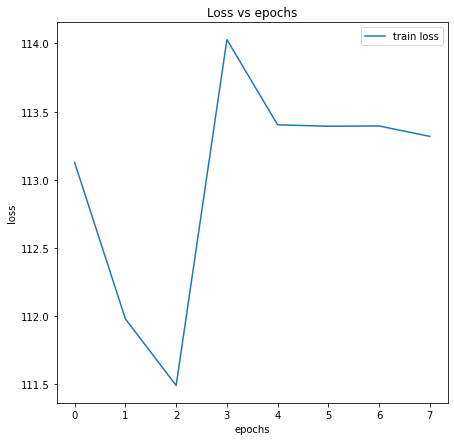

In [14]:
plt.figure(figsize=(7,7))
plt.plot(range(epochs), train_loss, label="train loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss vs epochs")
plt.legend(loc="best")
plt.show()

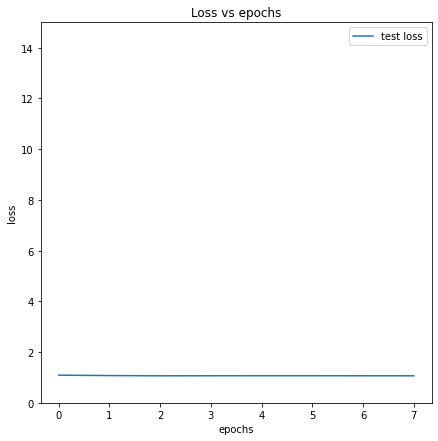

In [15]:
plt.figure(figsize=(7,7))
plt.plot(range(epochs), test_loss, label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 15)
plt.title("Loss vs epochs")
plt.legend(loc="best")
plt.show()

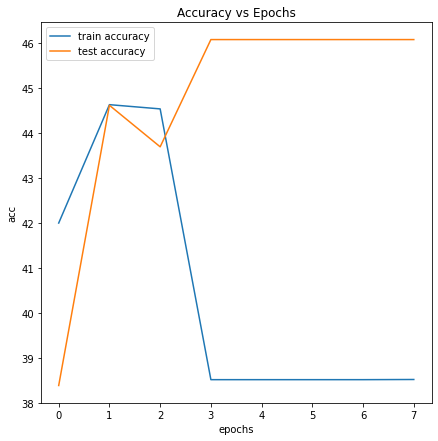

In [16]:
plt.figure(figsize=(7,7))
plt.plot(range(epochs), train_acc, label="train accuracy")
plt.plot(range(epochs), test_acc, label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Accuracy vs Epochs")
plt.legend(loc="best")
plt.show()

In [17]:
acc, f1, _ = test(model, X_test, y_test, batchsize=X_test.shape[0])
print("Test Accuracy : {:.2f} % ".format(acc))
print("Test Class-wise F1 Score : \n{}".format(f1))

Test Accuracy : 46.08 % 
Test Class-wise F1 Score : 
[0.         0.         0.63085835]
